In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import torch
import json
from ops.utils import*
from matplotlib.colors import ListedColormap
import os
import shutil 
from sam2.build_sam import build_sam2_video_predictor
from tqdm import tqdm

In [2]:
# use bfloat16 for the entire notebook
torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()

if torch.cuda.get_device_properties(0).major >= 8:
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

### Loading the SAM 2 video predictor

In [3]:
sam2_checkpoint = "../checkpoints/sam2_hiera_large.pt"
model_cfg = "sam2_hiera_l.yaml"
predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint)

/mnt/md126/users/mohamed/projects/segment-anything-2/sam2/modeling/sam/transformer.py:23: UserWarning: Flash Attention is disabled as it requires a GPU with Ampere (8.0) CUDA capability.
  OLD_GPU, USE_FLASH_ATTN, MATH_KERNEL_ON = get_sdpa_settings()


In [4]:



masks_directory = "/mnt/md126/users/mohamed/projects/AM/Data/Processed/Noisy_Pseudo_Masks/Andrii_12102024/masks_GT/"
raw_video_dir = "/mnt/md126/users/mohamed/projects/AM/Data/Processed/Noisy_Pseudo_Masks/Andrii_12102024/images_all/"

dataset_counter = 2
_unique_id=f'CIRP_ew8r3_d{dataset_counter}'
################





In [5]:
masks_directory

'/mnt/md126/users/mohamed/projects/AM/Data/Processed/Noisy_Pseudo_Masks/Andrii_12102024/masks_GT/'

In [6]:
import os

def normalize_image_names(directory):
    # Collect all files that match the pattern "<number>_<something>.<ext>"
    files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
    
    # Extract the numeric prefixes
    # For example, if filename = "30_1.png", prefix = "30"
    prefixes = []
    for f in files:
        parts = f.split('_', 1)
        if len(parts) > 1 and parts[0].isdigit():
            prefixes.append(parts[0])
    
    if not prefixes:
        # No matching filenames found, so nothing to do
        return
    
    # Determine the maximum length of the prefixes
    max_length = 5 # max(len(p) for p in prefixes)
    
    # Rename files to zero-pad their numeric prefixes
    for f in files:
        parts = f.split('_', 1)
        if len(parts) > 1 and parts[0].isdigit():
            num_str = parts[0].zfill(max_length)  # zero-pad the prefix
            new_name = num_str + "_" + parts[1]
            old_path = os.path.join(directory, f)
            new_path = os.path.join(directory, new_name)
            
            # Rename the file only if the new name is different
            if old_path != new_path:
                os.rename(old_path, new_path)


In [7]:
normalize_image_names(masks_directory)
normalize_image_names(raw_video_dir)

In [8]:
num_frames = 50
skiprate = 50 
data_set_tag = f'noisy_unique_id{_unique_id}'

masks_names = [
        p for p in os.listdir(masks_directory)
        if os.path.splitext(p)[-1].lower() in [".jpg", ".jpeg",'.png'] and f'_{dataset_counter}' in p
    ]


masks_names.sort()
masks_names_tr = masks_names[:5]
masks_names_val = masks_names[5:7]
masks_names_te = masks_names[7:]

all_images = [
        p for p in os.listdir(raw_video_dir)
        if os.path.splitext(p)[-1].lower() in [".jpg", ".jpeg",'.png'] and f'_{dataset_counter}' in p
    ]

all_images.sort()
all_images

sam_temp_dir = f"/mnt/md126/users/mohamed/projects/AM/Data/Processed/Noisy_Pseudo_Masks/Andrii_12102024/sam_temp/{data_set_tag}/"
sam_raw = f"{sam_temp_dir}/raw/"
sam_masks = f"{sam_temp_dir}/masks/"
sam_pred = f"{sam_temp_dir}/pred/"
sam_prompts = f"{sam_temp_dir}/sam_prompts/"
sam_pred_overlay = f"{sam_temp_dir}/pred_overlay/" 
os.makedirs(sam_temp_dir, exist_ok=True)
os.makedirs(sam_raw, exist_ok=True)
os.makedirs(sam_masks, exist_ok=True)
os.makedirs(sam_prompts, exist_ok=True)
os.makedirs(sam_pred, exist_ok=True)
os.makedirs(sam_pred_overlay, exist_ok=True)


In [9]:
import os
import shutil
from PIL import Image

def shift_and_convert(filename):
    # Example filename: '00090_1.png'
    # Split on underscore
    parts = filename.split('_', 1)
    prefix_str = parts[0]       # '00090'
    suffix_str = parts[1]       # '1.png'

    # Extract just the number from prefix
    prefix_num = int(prefix_str)

    # Decrement the frame number by 1
    prefix_num -= 1

    # Keep the same zero-padding length
    new_prefix_str = str(prefix_num).zfill(len(prefix_str))

    # Change extension to .jpg
    # suffix_str might be '1.png', so we split off the extension:
    suffix_parts = suffix_str.rsplit('.', 1)
    suffix_number = suffix_parts[0]  # '1'

    new_filename = f"{new_prefix_str}.jpg"
    return new_filename


for img in all_images:
    old_path = os.path.join(raw_video_dir, img)
    new_name = shift_and_convert(img)
    new_path = os.path.join(sam_raw, new_name)
    
    # Open with PIL and save as JPEG
    with Image.open(old_path) as im:
        im.convert('RGB').save(new_path, "JPEG")

for img in masks_names:
    old_path = os.path.join(masks_directory, img)
    new_name = shift_and_convert(img)
    new_path = os.path.join(sam_masks, new_name)
    
    # Open with PIL and save as JPEG
    with Image.open(old_path) as im:
        im.save(new_path, "JPEG")


In [10]:
parameters = {
    "model_name": "SAM 2",
    "raw_file_directory": raw_video_dir,
    "masks_directory": masks_directory,
    "num_frames": num_frames,
    "skiprate": skiprate,
    "unique_id": _unique_id,
    'sam2_checkpoint': sam2_checkpoint,
    'model_cfg': model_cfg
}

In [11]:
inference_state = predictor.init_state(video_path=sam_raw)
predictor.reset_state(inference_state)

frame loading (JPEG): 100%|██████████| 300/300 [00:07<00:00, 42.38it/s]


In [12]:
print(predictor.fill_hole_area, predictor.non_overlap_masks, predictor.clear_non_cond_mem_around_input, predictor.clear_non_cond_mem_for_multi_obj)

8 False False False


In [13]:
gt_masks = os.listdir(sam_masks)
gt_masks.sort()
gt_masks[:5]

['00029.jpg', '00059.jpg', '00089.jpg', '00119.jpg', '00149.jpg']

/mnt/md126/users/mohamed/projects/segment-anything-2/sam2/sam2_video_predictor.py:873: UserWarning: cannot import name '_C' from 'sam2' (/mnt/md126/users/mohamed/projects/segment-anything-2/sam2/__init__.py)

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/segment-anything-2/blob/main/INSTALL.md).
  pred_masks_gpu = fill_holes_in_mask_scores(


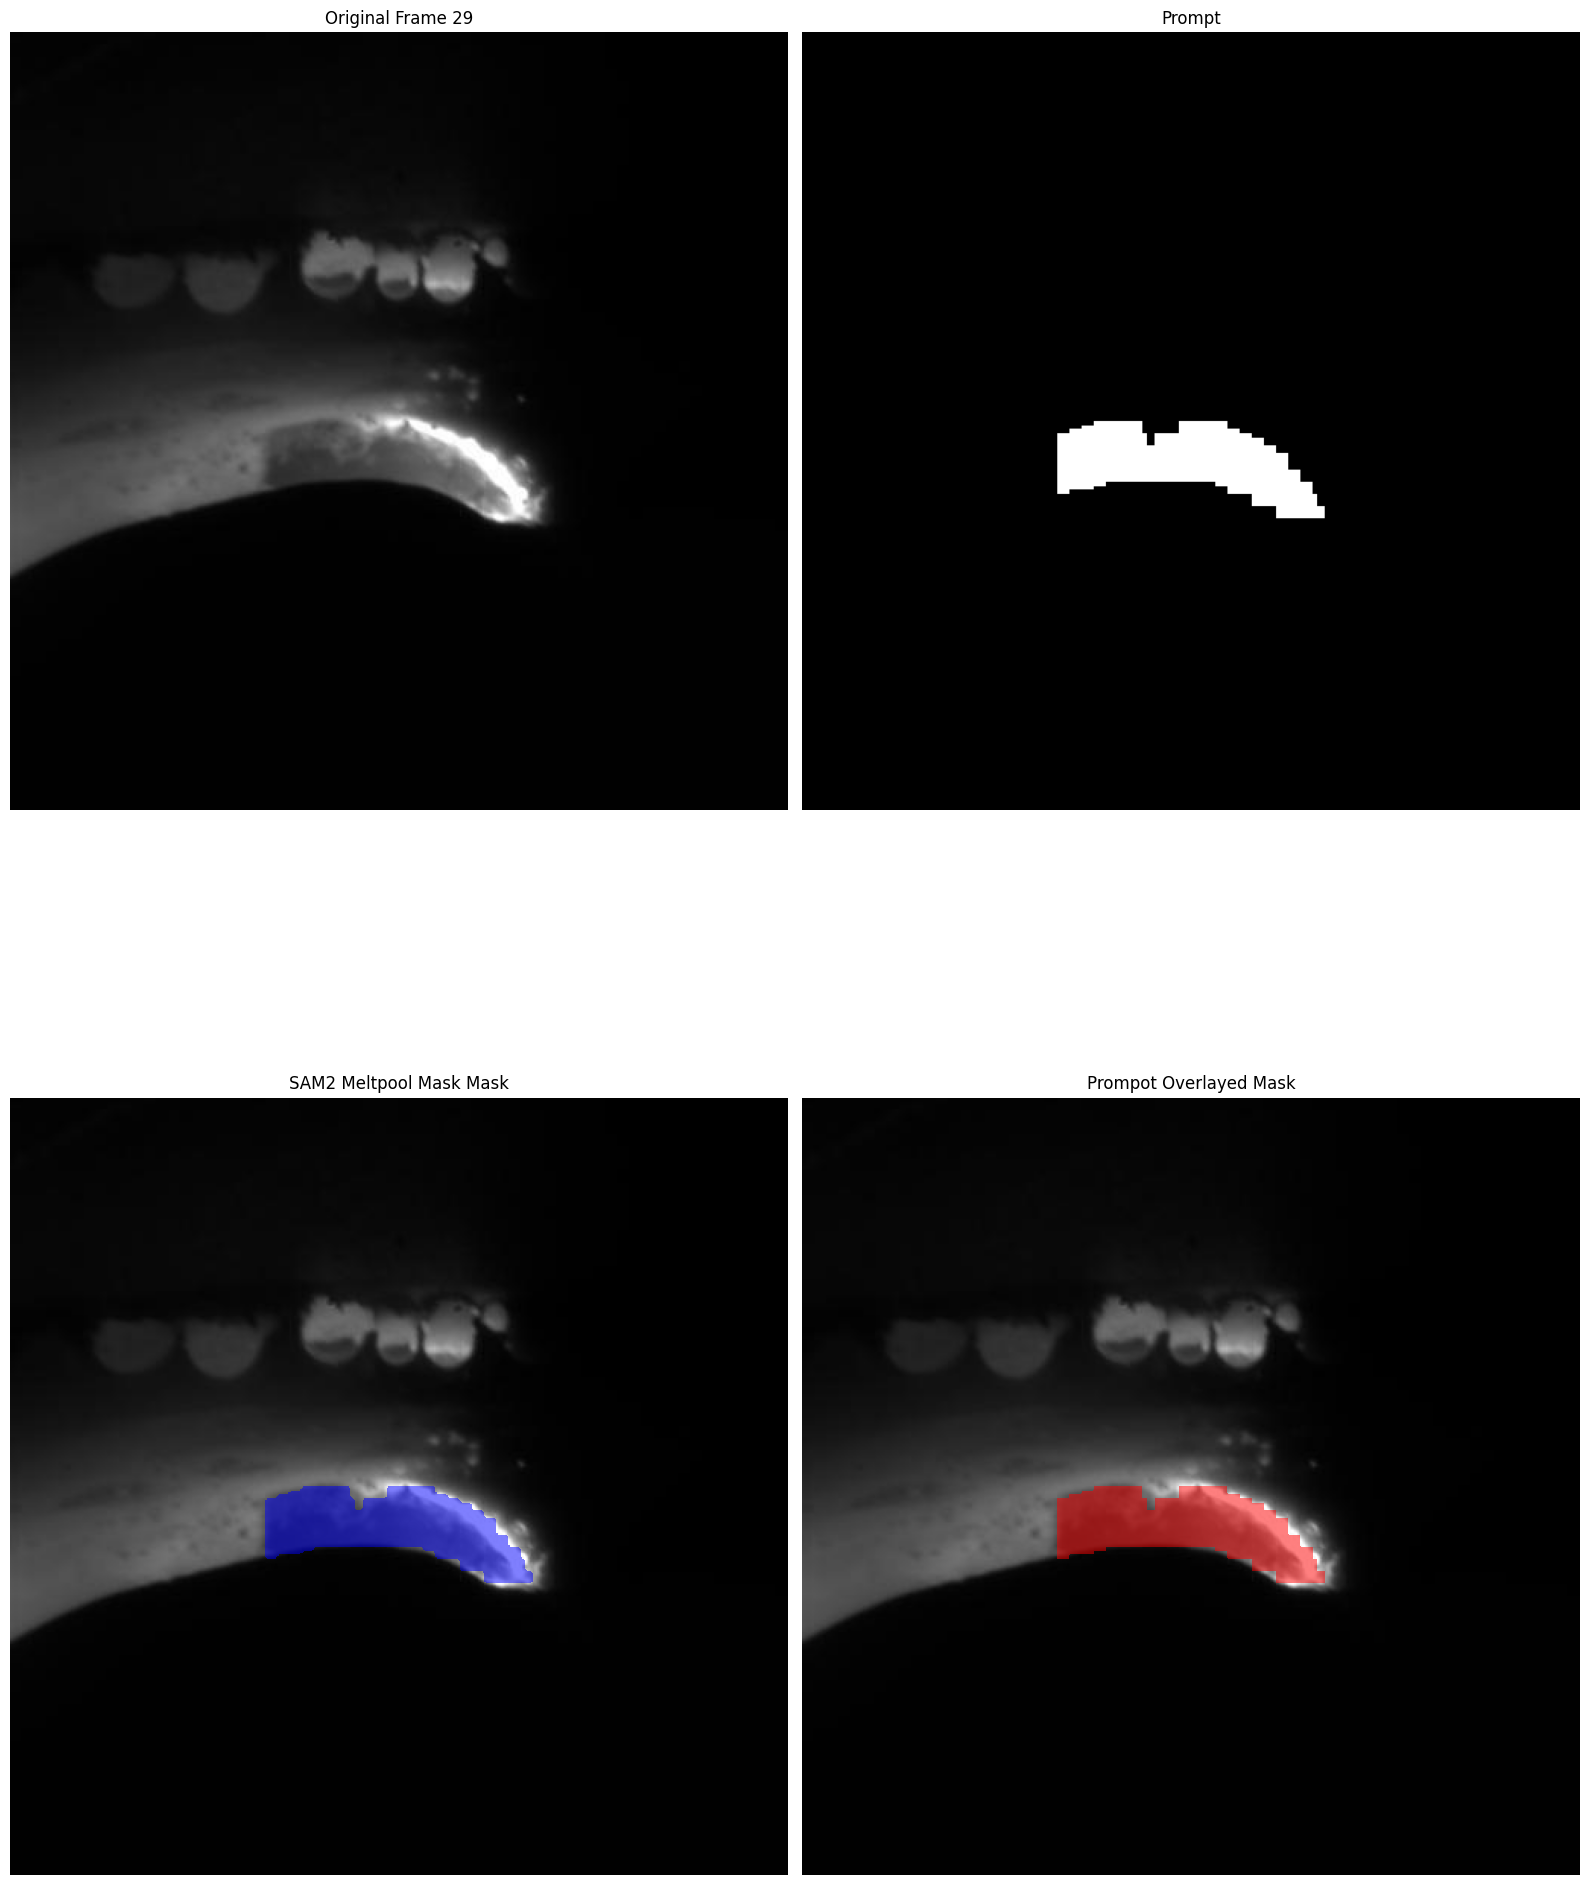

/mnt/md126/users/mohamed/projects/segment-anything-2/sam2/sam2_video_predictor.py:873: UserWarning: cannot import name '_C' from 'sam2' (/mnt/md126/users/mohamed/projects/segment-anything-2/sam2/__init__.py)

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/segment-anything-2/blob/main/INSTALL.md).
  pred_masks_gpu = fill_holes_in_mask_scores(


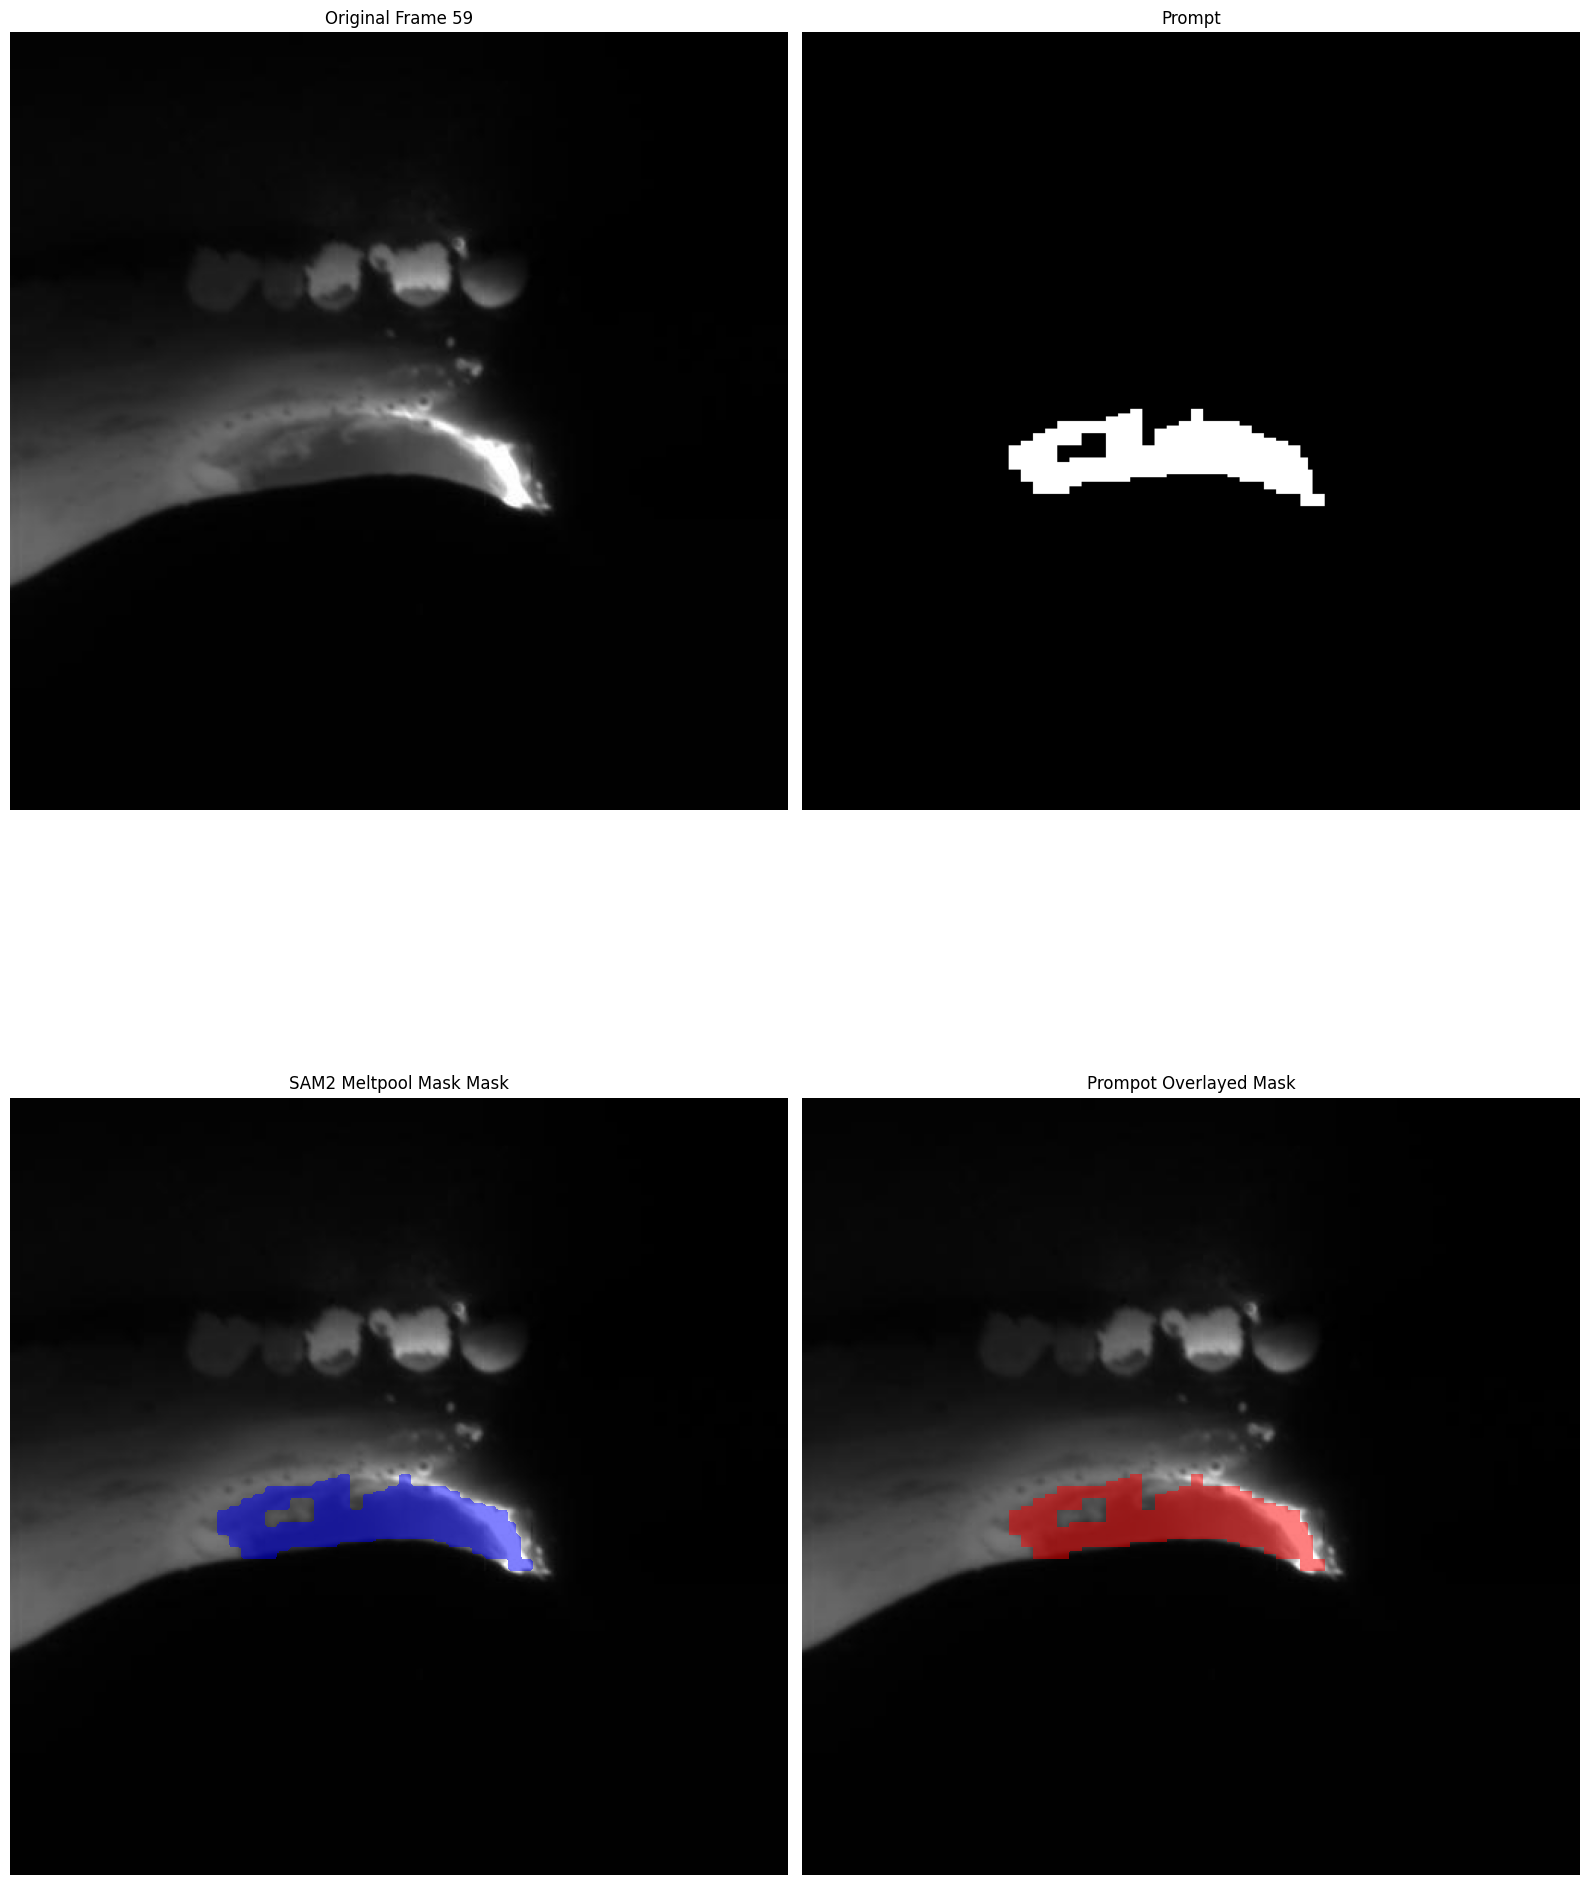

/mnt/md126/users/mohamed/projects/segment-anything-2/sam2/sam2_video_predictor.py:873: UserWarning: cannot import name '_C' from 'sam2' (/mnt/md126/users/mohamed/projects/segment-anything-2/sam2/__init__.py)

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/segment-anything-2/blob/main/INSTALL.md).
  pred_masks_gpu = fill_holes_in_mask_scores(


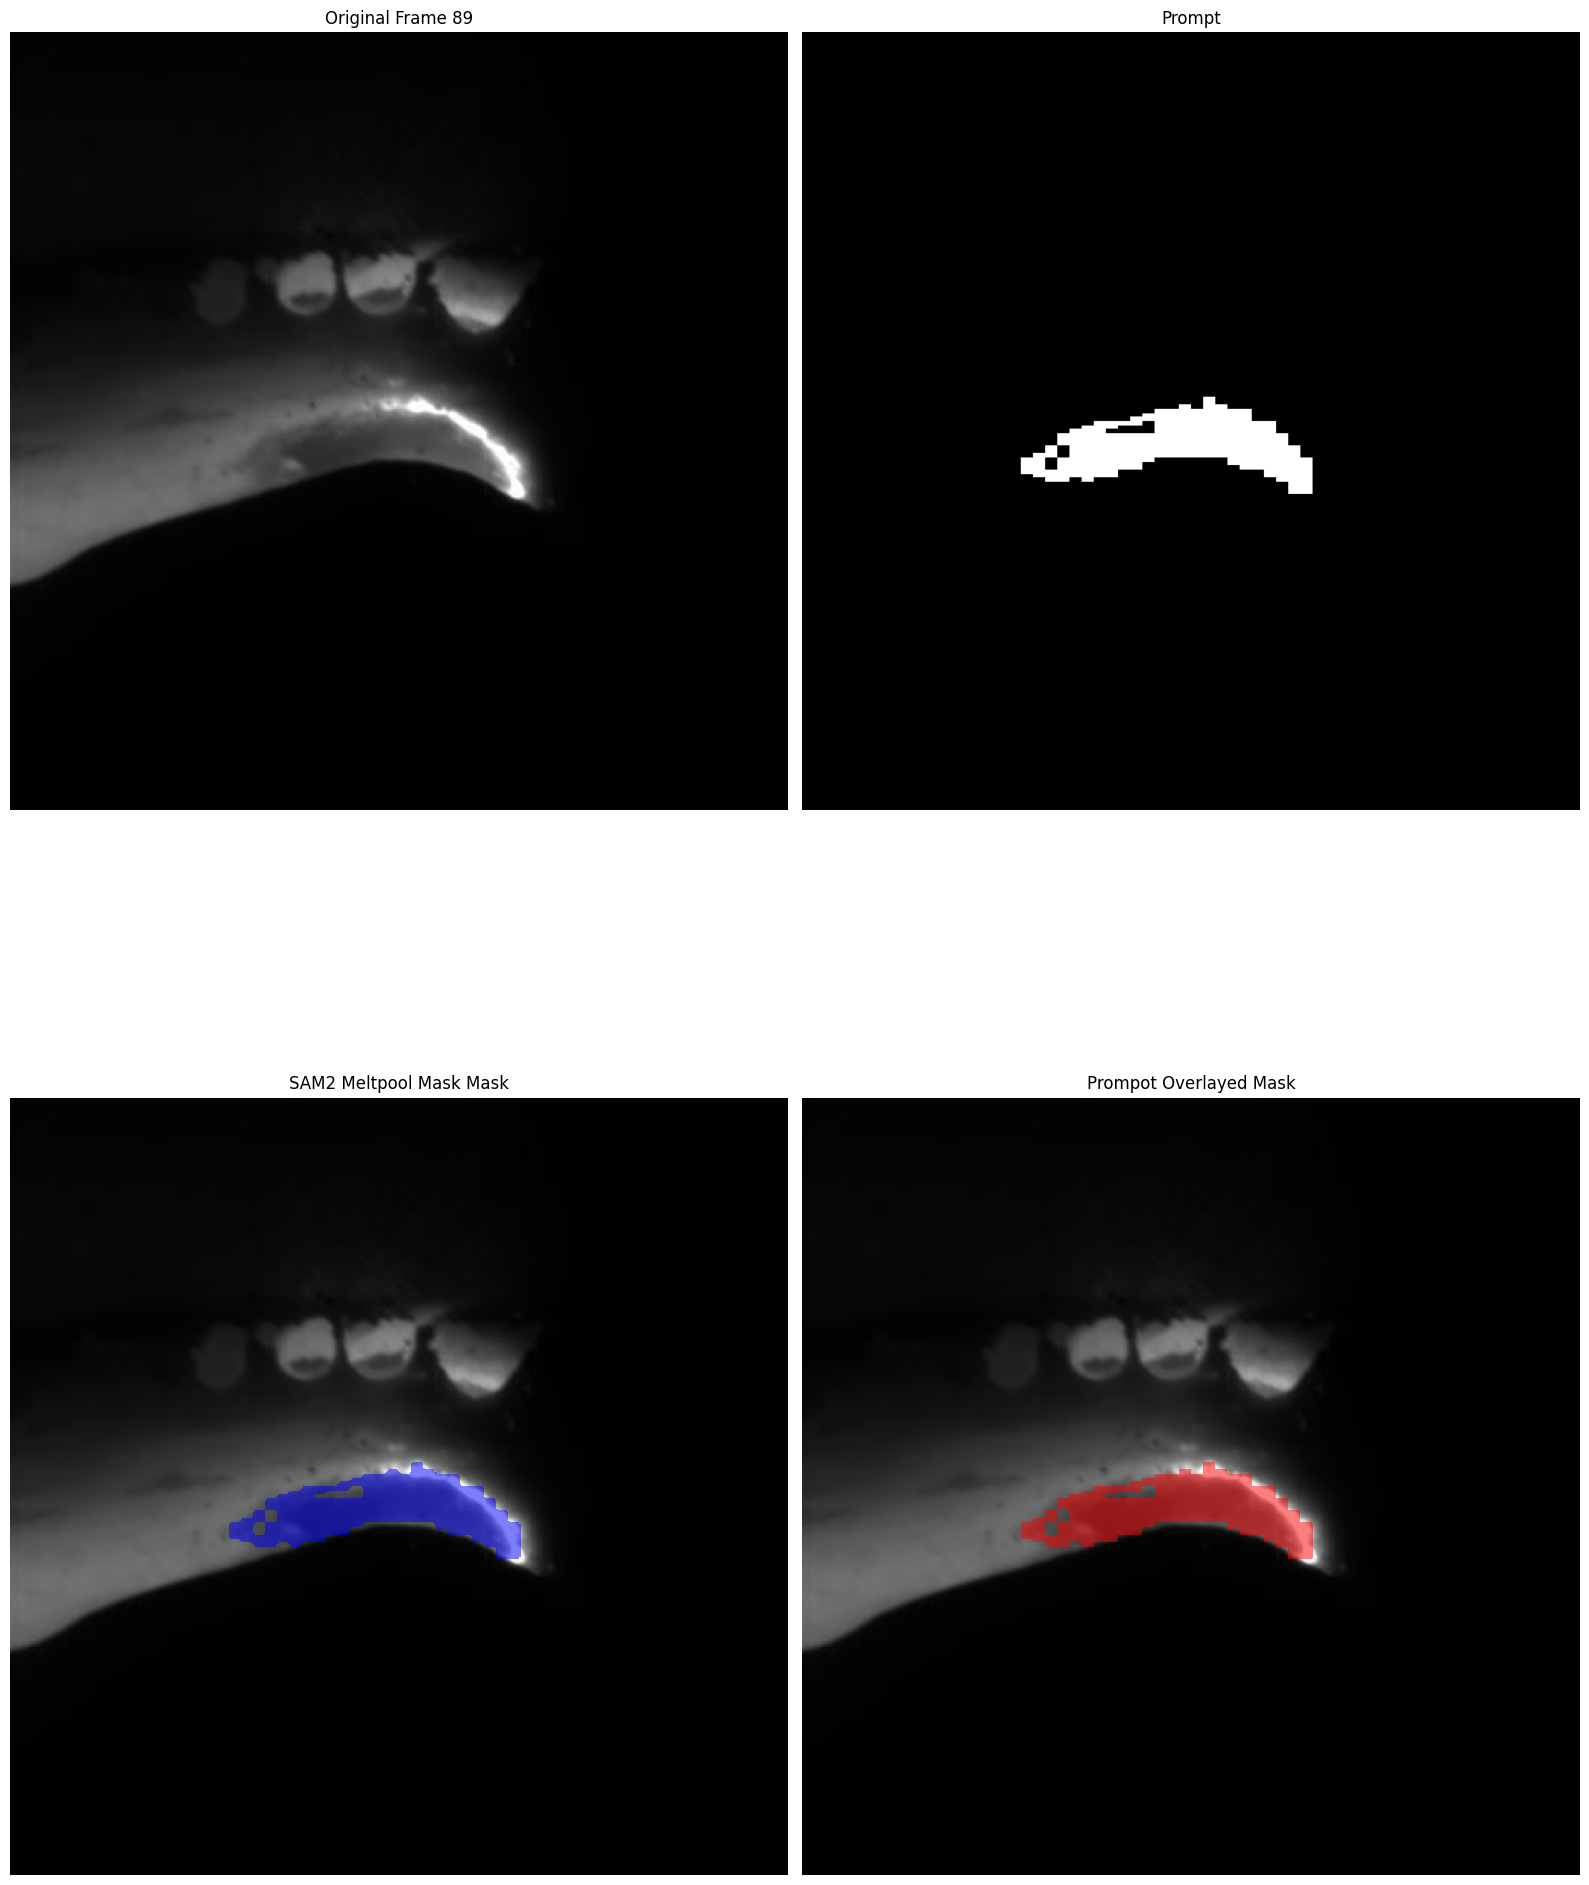

/mnt/md126/users/mohamed/projects/segment-anything-2/sam2/sam2_video_predictor.py:873: UserWarning: cannot import name '_C' from 'sam2' (/mnt/md126/users/mohamed/projects/segment-anything-2/sam2/__init__.py)

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/segment-anything-2/blob/main/INSTALL.md).
  pred_masks_gpu = fill_holes_in_mask_scores(


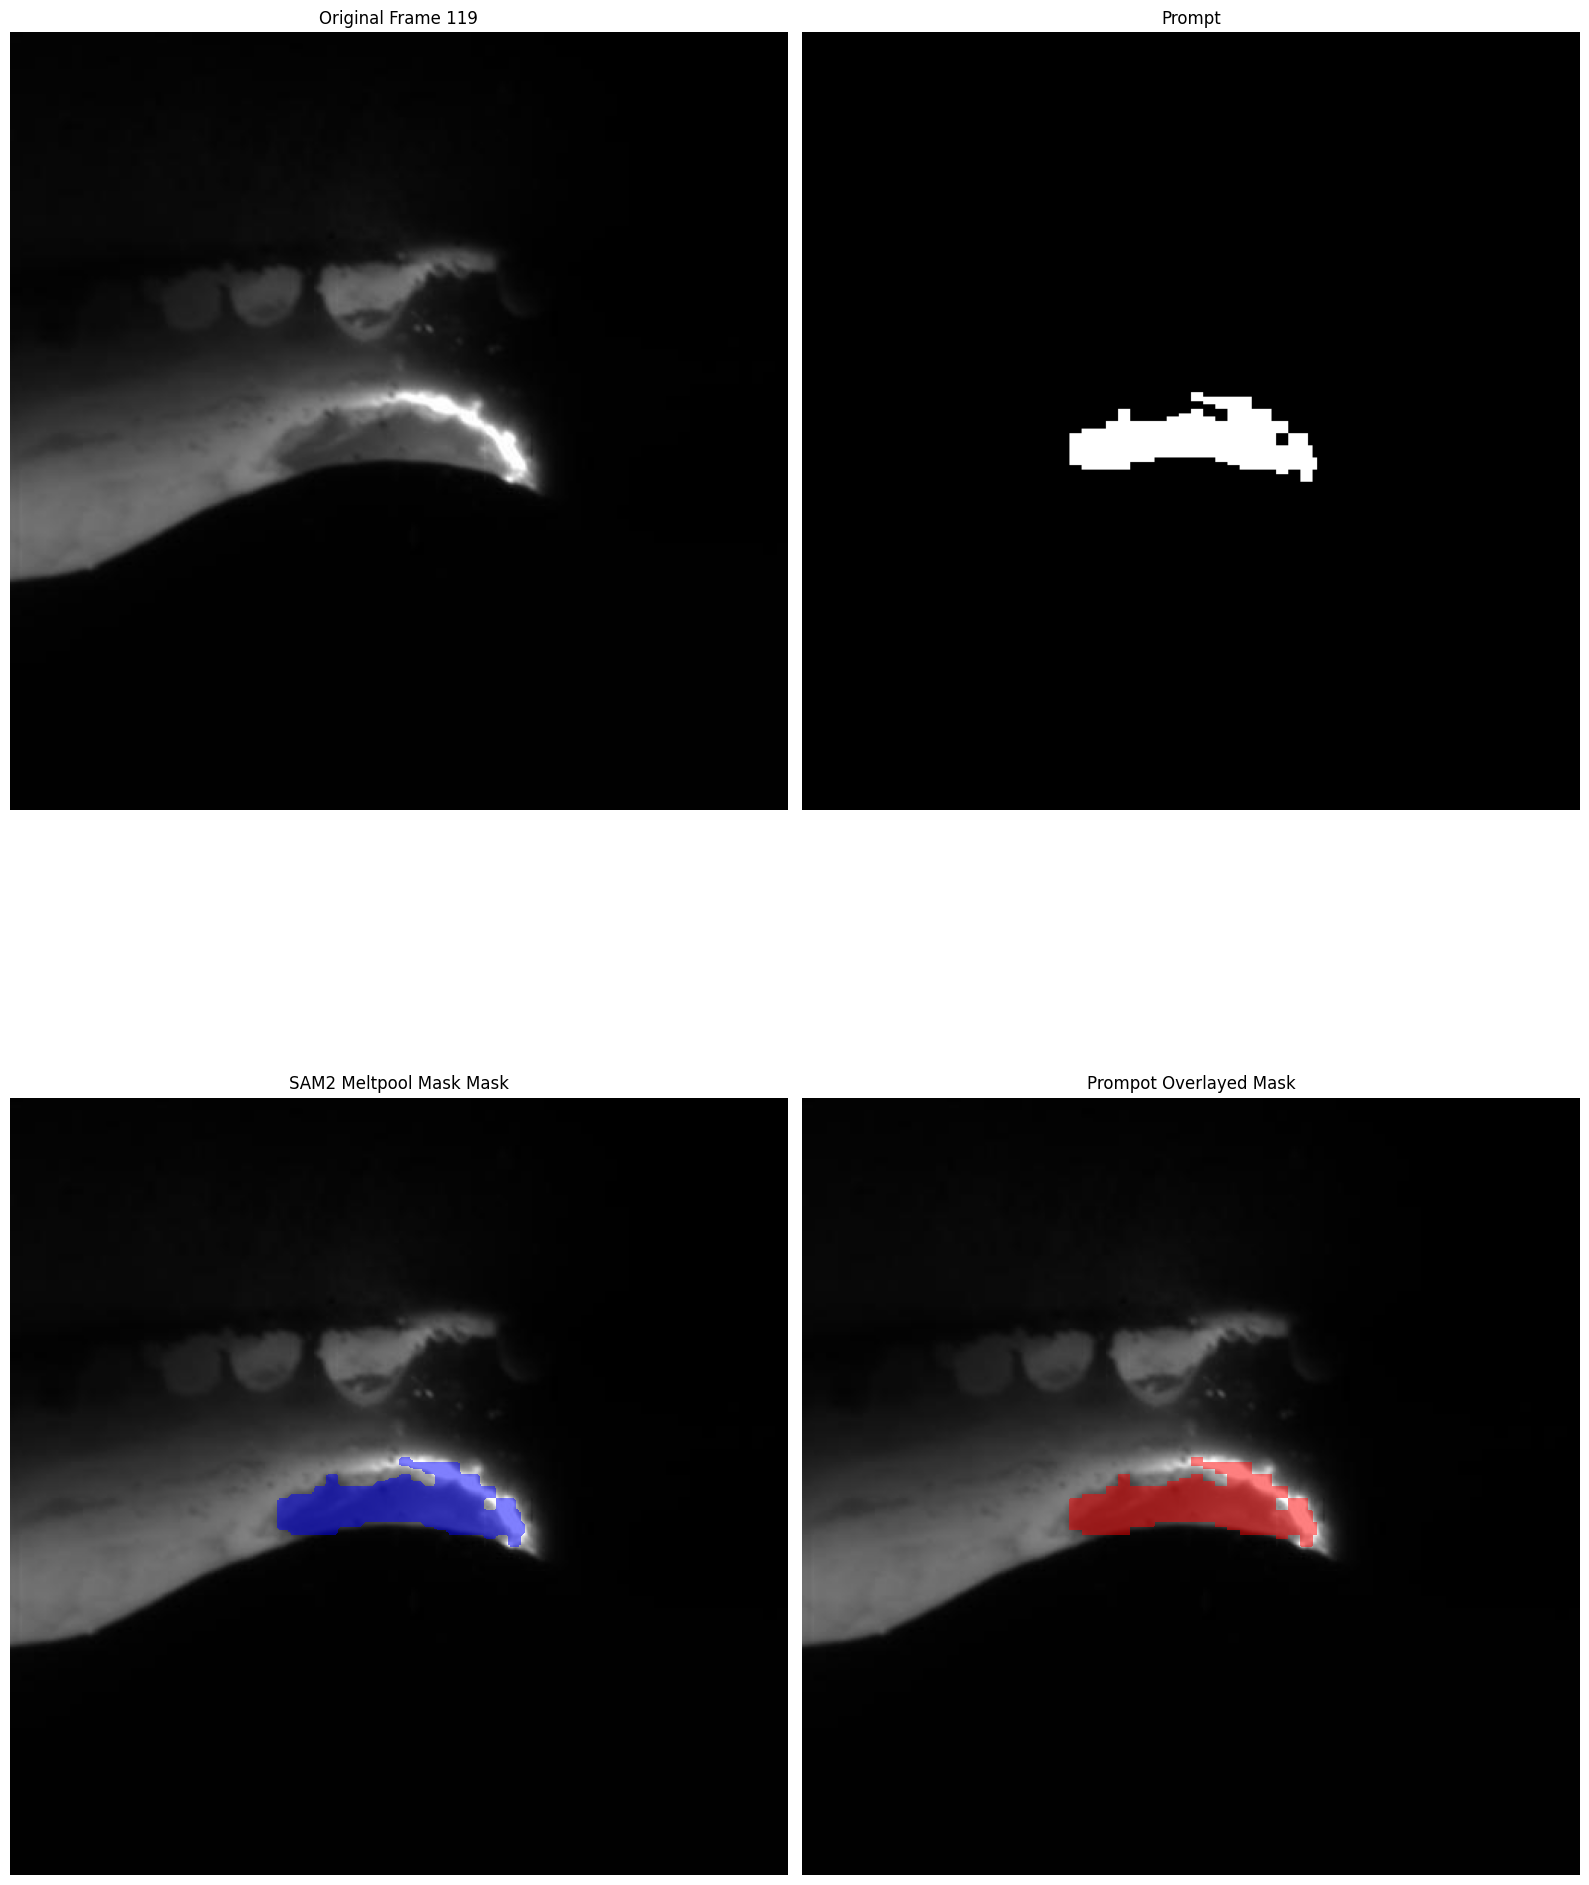

/mnt/md126/users/mohamed/projects/segment-anything-2/sam2/sam2_video_predictor.py:873: UserWarning: cannot import name '_C' from 'sam2' (/mnt/md126/users/mohamed/projects/segment-anything-2/sam2/__init__.py)

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/segment-anything-2/blob/main/INSTALL.md).
  pred_masks_gpu = fill_holes_in_mask_scores(


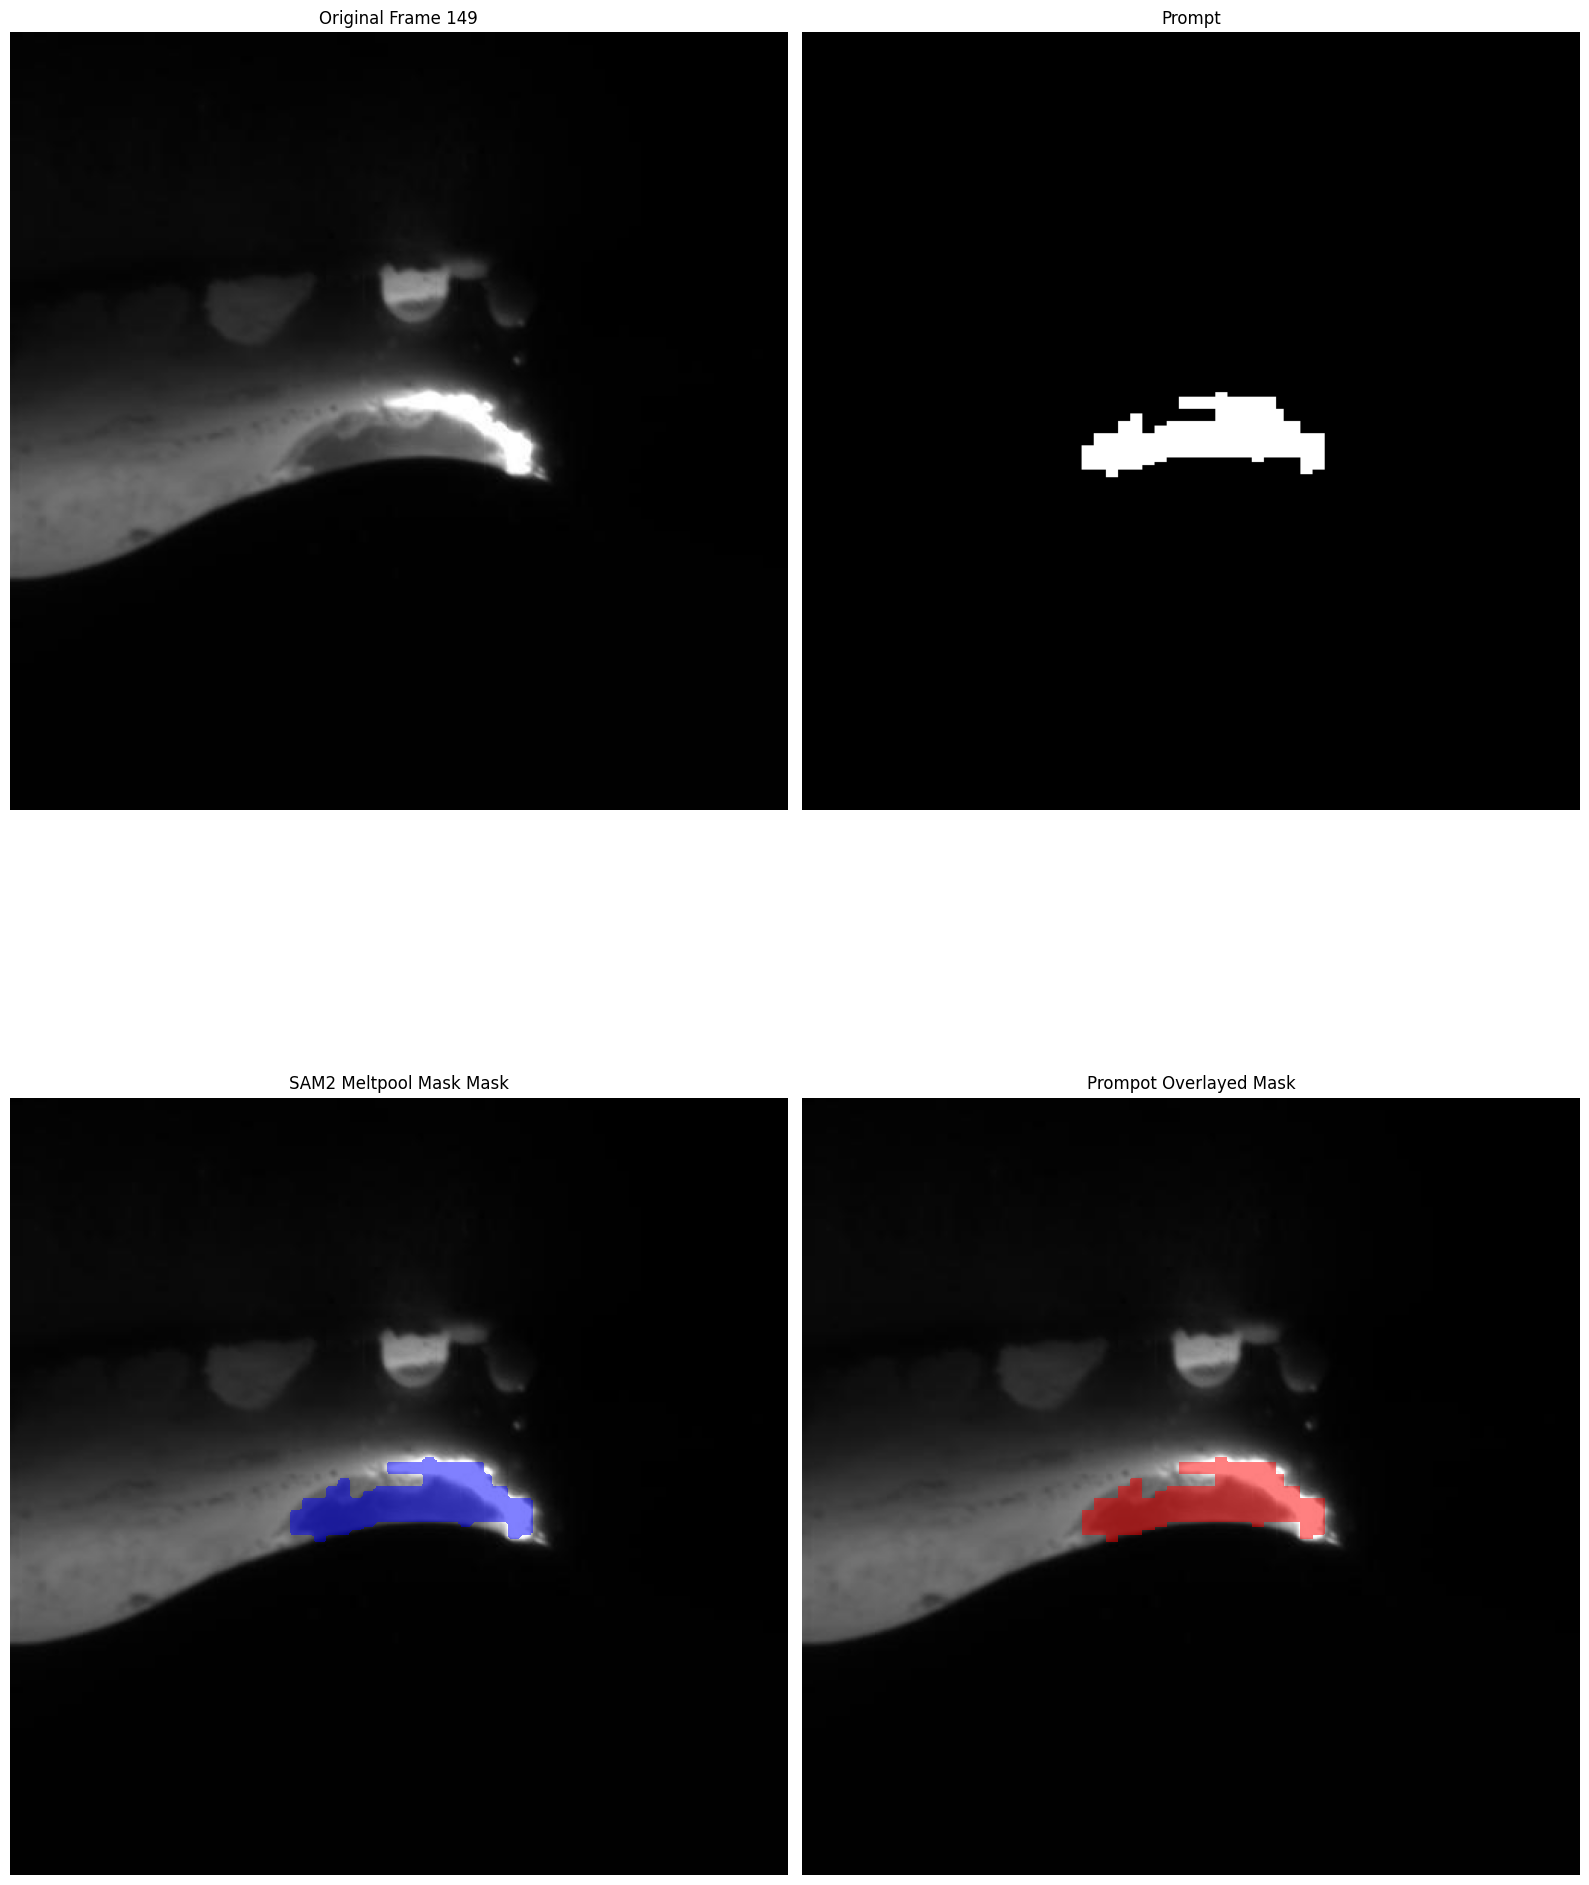

In [14]:
# Load the image and masks
ann_obj_id = 1  # give a unique id to each object we interact with (it can be any integers)

for mask in gt_masks[:5]:
    mask_frame_array = np.array(Image.open(f"{sam_masks}/{mask}"))
    image = np.array(Image.open(f"{sam_raw}/{mask}"))
    mask_index = int(mask.split('.')[0])
    meltpool_mask = mask_frame_array > 0

    _, out_obj_ids, out_mask_logits = predictor.add_new_mask(
        inference_state=inference_state,
        frame_idx=mask_index, # sam index
        obj_id=ann_obj_id,
        mask=meltpool_mask,
    )

    # Create a figure with 4x2 subplots
    fig, axs = plt.subplots(2, 2, figsize=(16, 24))
    # Display images and masks


    axs[0, 1].imshow(meltpool_mask, cmap='gray')
    axs[0, 1].set_title('Prompt')
    axs[0, 1].axis('off')


    axs[0, 0].imshow(image, cmap="gray")
    axs[0, 0].set_title(f"Original Frame {mask_index}")
    axs[0, 0].axis('off')
    axs[1, 0].imshow(image)
    single_color_cmap_blue = ListedColormap(['none', 'blue']) 
    SAM2_Mask= (out_mask_logits[0] > 0.0).cpu().numpy().squeeze()
    axs[1, 0].imshow(SAM2_Mask, alpha=0.5,cmap=single_color_cmap_blue)  
    axs[1, 0].set_title('SAM2 Meltpool Mask Mask')
    axs[1, 0].axis('off')

    # Overlay meltpool mask on the original image
    single_color_cmap_red = ListedColormap(['none', 'red']) 
    axs[1, 1].imshow(image, cmap='gray')
    axs[1, 1].imshow(meltpool_mask, alpha=0.5,cmap=single_color_cmap_red)  
    axs[1, 1].set_title('Prompot Overlayed Mask')
    axs[1, 1].axis('off')
    
    

    plt.tight_layout()
    plt.savefig(f"{sam_prompts}/all_masks_{mask}")
    plt.show()
    plt.close()


#### Step 3: Propagate the prompts to get the masklet across the video

To get the masklet throughout the entire video, we propagate the prompts using the `propagate_in_video` API.

In [15]:
# Assuming out_mask_logits are raw logits, and assuming we are only intrested in single object, we convert them to probabilities for confidence calculation
sigmoid = torch.nn.Sigmoid()
# run propagation throughout the video and collect the results in a dict
video_segments = {}  # video_segments contains the per-frame segmentation results
frame_metrics = {}  # mask_confidence contains the per-frame mask confidence scores
frame_metrics['mask_confidence'] = {}
frame_metrics['frame'] = {}
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
        # out_frame_idx is according sam index
        mask = (out_mask_logits[ann_obj_id-1] > 0.0).cpu().numpy() #
        video_segments[out_frame_idx] = mask # collection of sam results
        # Convert logits to probabilities for the current mask
        probabilities = sigmoid(out_mask_logits[ann_obj_id-1]).cpu().numpy()
        frame_metrics['mask_confidence'][out_frame_idx] = probabilities[mask].mean()  # Mean confidence of the mask
        # frame_metrics['frame'] [out_frame_idx] = frames_indices[out_frame_idx]
        # np.save(os.path.join(sam_pred, f"frame_{out_frame_idx+1}_probabilities.npy"), probabilities)
        
        

propagate in video:   0%|          | 1/271 [00:00<00:58,  4.63it/s]/mnt/md126/users/mohamed/projects/segment-anything-2/sam2/sam2_video_predictor.py:873: UserWarning: cannot import name '_C' from 'sam2' (/mnt/md126/users/mohamed/projects/segment-anything-2/sam2/__init__.py)

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/segment-anything-2/blob/main/INSTALL.md).
  pred_masks_gpu = fill_holes_in_mask_scores(
propagate in video: 100%|██████████| 271/271 [01:59<00:00,  2.26it/s]


In [16]:
# scan all the JPEG frame names in this directory
frame_names = [
    p for p in os.listdir(sam_raw)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
]
frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))

In [17]:
# frame_names

In [18]:
vis_dpi = 1200  
single_color_cmap_blue = ListedColormap(['none', 'blue'])
width = 512
height = 512

parameters['vis_dpi'] = vis_dpi
parameters['width'] = width
parameters['height'] = height

# Calculate figure size in inches
fig_width = width / vis_dpi
fig_height = height / vis_dpi
max_digits = len(str(999999999999))
plt.close("all")
frame_metrics['file_name'] = {}
for out_frame_idx in tqdm(video_segments.keys()):
    plt.figure(figsize=(fig_width, fig_height), dpi=vis_dpi)
    plt.imshow(Image.open(os.path.join(sam_raw, frame_names[out_frame_idx])), cmap='gray')
    plt.axis('off')
    plt.tight_layout(pad=0)  # Set padding to zero for tight layout
    plt.subplots_adjust(wspace=0, hspace=0)  # Remove any space between subplots
    out_mask = video_segments[out_frame_idx]
    plt.imshow(out_mask.squeeze(), alpha=0.25, cmap=single_color_cmap_blue)
    out_frame_idx_str = str(out_frame_idx+1).zfill(max_digits)
    plt.savefig(f"{sam_pred_overlay}/{out_frame_idx_str}.png")

    # Save the mask alone
    plt.figure(figsize=(fig_width, fig_height), dpi=vis_dpi)
    plt.imshow(out_mask.squeeze(), alpha=1, cmap=ListedColormap(['black', 'white']))
    plt.axis('off')
    plt.tight_layout(pad=0)  # Set padding to zero for tight layout
    plt.subplots_adjust(wspace=0, hspace=0)  # Remove any space between subplots
    plt.savefig(f"{sam_pred}/{out_frame_idx_str}.png")
    plt.close("all")


100%|██████████| 271/271 [00:30<00:00,  8.88it/s]


In [19]:
# Save to JSON file
json_file_path = os.path.join(sam_temp_dir, f"parameters.json")  # Saving in the same directory as your CSV
with open(json_file_path, 'w') as json_file:
    json.dump(parameters, json_file, indent=4)
print(f"Parameters saved to {json_file_path}")

Parameters saved to /mnt/md126/users/mohamed/projects/AM/Data/Processed/Noisy_Pseudo_Masks/Andrii_12102024/sam_temp/noisy_unique_idCIRP_ew8r3_d2/parameters.json


In [20]:
import os
from IPython.display import display, clear_output
from ipywidgets import widgets
from PIL import Image
import time

def create_image_animation(folder_path, frame_rate=1):
    """Create an interactive image animation in a Jupyter Notebook.

    Args:
    folder_path (str): Path to the folder containing images.
    frame_rate (float): Number of seconds between frames.
    """
    # List all files in the directory and sort them
    files = sorted([os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))])
    # print(f"Found {len(files)} images in {folder_path}")
    # print(f'Files are {files}')
    # Display widget setup
    output = widgets.Output()
    play_button = widgets.Button(description="Play")
    stop_button = widgets.Button(description="Stop")
    slider = widgets.IntSlider(value=0, min=0, max=len(files) - 1, step=1, description='Frame:')
    play_control = widgets.Play(value=0, min=0, max=len(files) - 1, interval=1000 * frame_rate, show_repeat=False)
    widgets.jslink((play_control, 'value'), (slider, 'value'))  # Link slider and play widget

    # Event handlers for buttons
    def play_animation(b):
        play_control._playing = True

    def stop_animation(b):
        play_control._playing = False

    play_button.on_click(play_animation)
    stop_button.on_click(stop_animation)

    # Function to display the current frame
    def show_current_frame(change):
        frame_index = change['new']
        if output.outputs:  # if there is something already displayed
            output.clear_output(wait=True)
        with output:
            display(Image.open(files[frame_index]))

    slider.observe(show_current_frame, names='value')

    # Arrange buttons and slider
    control_panel = widgets.HBox([play_button, stop_button, slider])
    display(control_panel, play_control, output)

    # Initialize
    show_current_frame({'new': slider.value})




In [21]:
# Example usage
create_image_animation(sam_pred_overlay, frame_rate=0.5)

Play(value=0, interval=500, max=270, show_repeat=False)

Output()